In [6]:
%load_ext autoreload
%autoreload 2
import datetime 
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from setdir import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Slocum gliders: Serial numbers
unit_list = ['unit_398', 'unit_409']

# Formatting string for date/time to use in filenaming
time_strf = '%Y%m%d'

# Name the file according to what date?
# Currently implemented: Date file was created
# Alternate option: end date of data record
yyyymmdd = datetime.datetime.now().strftime(time_strf)

# Time limits
datestart = '2021-12-12'
tstart = pd.Timestamp('2021-12-12T00')

# Initialise the figure directory
figdir = create_figdir()

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

In [8]:
# Load the latest data in
int_dir = cat_interim_path('')
unit_to_do = []

# Extract a list with the names of existing raw data files.
for i in unit_list:
    fname = i+'_*_edit.nc'
    existing_files = glob.glob(cat_interim_path(fname))

    if len(existing_files) > 0:
        existing_files = sorted(existing_files)
        end_date = (existing_files[-1])[-16:-8]
        t1 = datetime.datetime.strptime(end_date, time_strf)
        
        proc_files = glob.glob(cat_proc_path(fname))
        if len(proc_files) > 0:
            end_date_proc = (proc_files[-1])[-16:-8]
            t_proc = datetime.datetime.strptime(end_date_proc, time_strf)

            print(i+' - Previous file ended: '+t_proc+', New end: '+end_date)
            if t_proc < t1:
                unit_to_do.append(i)
        else:
            print(i+' - Need to process')
            unit_to_do.append(i)
            

unit_398 - Need to process
unit_409 - Need to process


In [11]:
presname = 'pressure_dbar'

# Load data and separate by climbing or diving
for i in unit_to_do:
    fname = i+'_*_edit.nc'
    existing_files = glob.glob(cat_interim_path(fname))
    
    existing_files = sorted(existing_files)
    ds_int = xr.open_dataset(existing_files[-1])
    
    pres = ds_int[presname]

    
    #updn = np.zeros(len(pres), dtype='int')

    #for i in range(len(pres)-1):
    #    inext = i+1
    #    pstart = pres[i]
    #    pnext = pres[inext]

    #    if pnext>pstart:
    #        updn[i] = -1
    #    else:
    #        updn[i] = 1
            
    #ds_int['updn'] = ('time', updn)
    
np.diff(pres)
updn = np.zeros(len(pres), dtype='int')
climbing = (np.diff(pres)>0)
diving = (np.diff(pres)<0)

(30000.0, 35000.0)

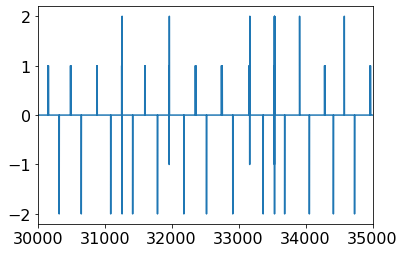

In [24]:
iup = np.where(climbing)
idn = np.where(diving)
updn[iup] = 1
updn[idn] = -1
plt.plot(np.diff(updn))
plt.xlim([30000, 35000])

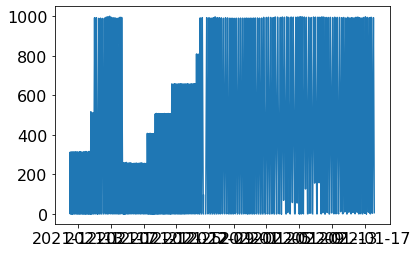

In [25]:
# Identifying separate profiles
timename = 'time'
presname = 'pressure_dbar'
plt.plot(ds_int[timename], ds_int[presname])

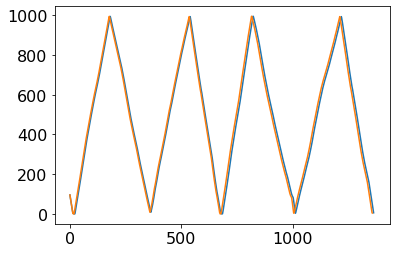

In [27]:
# Get a bit of recent data
ndays = 1
max_time = ds_int.time.max().values
dt1 = np.timedelta64(-ndays, 'D')
ds1 = ds_int.where(ds_int[timename]>=(max_time+dt1), drop=True)
plt.plot(ds1[presname])

maxp = ds1[presname].max().values
minp = ds1[presname].min().values
pres = ds1[presname].values
ds2 = ds1.where(~np.isnan(ds1[presname]), drop=True)
pres = ds2[presname].values
plt.plot(pres)

updn = np.zeros(len(pres), dtype='int')

iup = np.where(np.diff(pres)>0)
idn = np.where(np.diff(pres)<0)
updn[iup] = 1
updn[idn] = -1
        

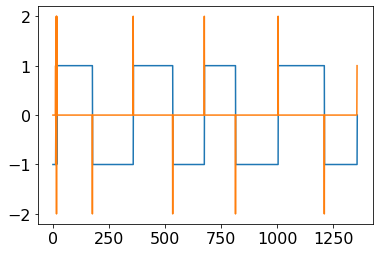

In [28]:
plt.plot(updn)
plt.plot(np.diff(updn))

-0.030000001424923
-0.06000000052154
0.014999997802077999


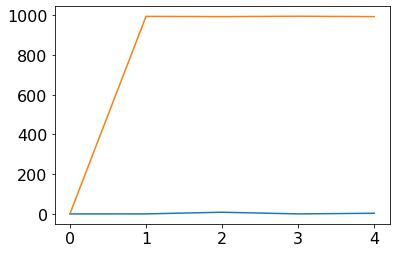

In [165]:
# Identify indices in the pressure vector where the direction (increasing
# vs decreasing pressure) switched
isurftuple = np.where(np.diff(updn)==2)
isurf = isurftuple[0]+1
# Index of deepest values, increment by one
ibottomtuple = np.where(np.diff(updn)==-2)
ibottom = ibottomtuple[0]+1

# Verifying that index of apogees need to be incremented by 1.
# Middle value should be the extremum
t1 = isurf
print(pres[t1[3]-1])
print(pres[t1[3]])
print(pres[t1[3]+1])
plt.plot(pres[isurf])
plt.plot(pres[ibottom])


In [170]:
# Now I need to remove local maxima or local minimum that aren't true apogees
# A few options:
#.   They are nearby in time
#.   It picks near bottom apogees shallower than 10m ( but this won't remove intervening surface apogees)
#.   Find the bottom turnaround points, then search either direction for the surfacing or near surface positions (remember there could be subsurface turnarounds)

# Remove any indices from ibottom where pressure is less than 10 dbar
iremove = ibottom[(np.where(pres[ibottom]<10))[0]]
for i in iremove:
    ibottom = np.delete(ibottom, np.argwhere(ibottom == i))
ibottom = ibottom.flatten()


[  16   18  177  359  535  676  815 1005 1211]
[  18  177  359  535  676  815 1005 1211]


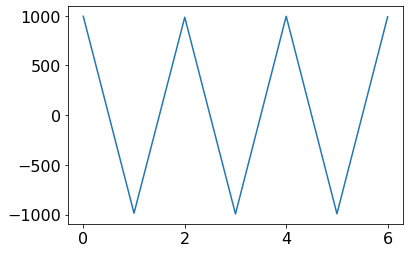

In [175]:
# Combine the surface indices and the bottom indices
iapogee = np.sort(np.concatenate((isurf, ibottom), axis=0))
print(iapogee)


# Check how many dbar apart they are
dpres = np.diff(pres[iapogee])
#print(dpres)
iremove = iapogee[np.where(abs(dpres)<10)]
for i in iremove:
    iapogee = np.delete(iapogee, np.argwhere(iapogee==i))
iapogee = iapogee.flatten()

print(iapogee)
dpres = np.diff(pres[iapogee])
plt.plot(dpres)
#plt.plot(pres[iapogee])

In [177]:
print(len(pres))
iupdn = np.zeros(len(pres), dtype='int')

for i in range(len(iapogee)-1):
    if pres[iapogee[i+1]]>pres[iapogee[i]]:
        diveval = -1
    else:
        diveval = 1
    iupdn[iapogee[i]:iapogee[i+1]] = diveval
    
    



1358


<xarray.Dataset>
Dimensions:                        (time: 1367)
Coordinates:
  * time                           (time) datetime64[ns] 2022-01-17T04:11:00 ...
Data variables:
    sci_water_temp                 (time) float64 3.247 3.243 3.217 ... nan 3.19
    sci_water_cond                 (time) float64 3.151 3.15 3.148 ... nan 3.142
    sci_oxy4_oxygen                (time) float64 388.5 388.7 ... nan 389.3
    derived_salinity               (time) float64 nan nan nan ... nan nan 34.5
    derived_potential_density      (time) float64 nan nan nan ... nan 1.027e+03
    derived_potential_temperature  (time) float64 nan nan nan ... nan nan 3.19
    m_gps_lon                      (time) float64 nan nan nan ... -57.1 nan
    m_gps_lat                      (time) float64 nan nan nan ... 59.57 nan
    pressure_dbar                  (time) float64 95.3 88.06 80.8 ... nan 4.23

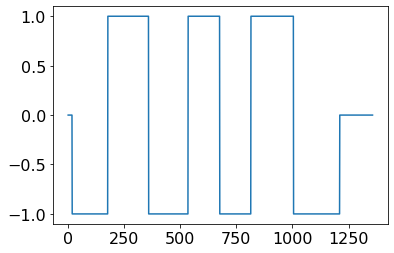

In [179]:
plt.plot(iupdn)
ds1

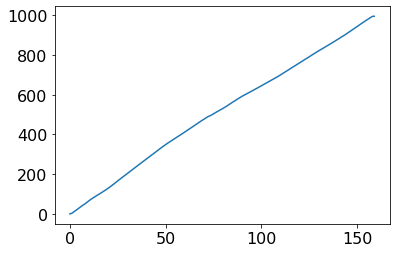

pause 


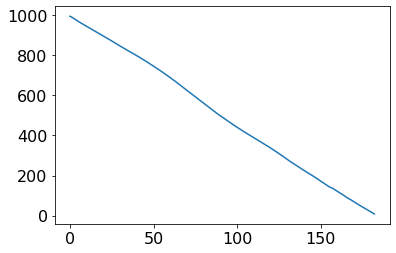

pause 


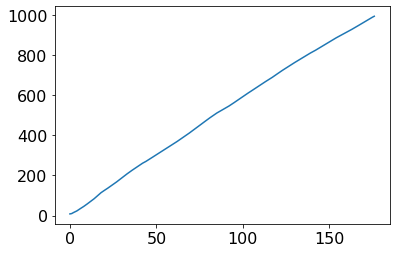

pause 


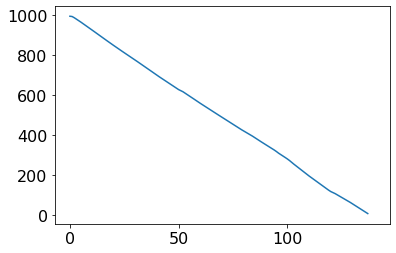

pause 


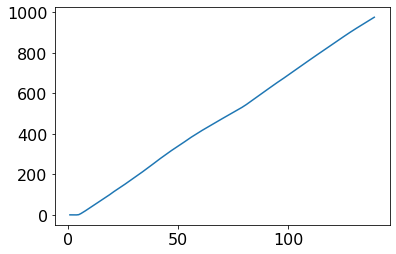

pause 


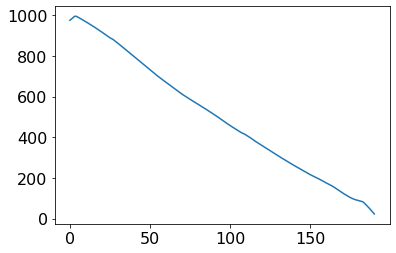

pause 


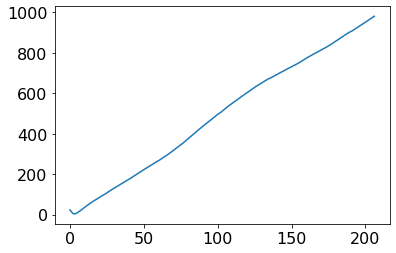

KeyboardInterrupt: Interrupted by user

In [238]:
# Separate profiles
presvec = ds1[presname].values

for i in range(len(iapogee)-1):
    tslice = slice(iapogee[i]+4, iapogee[i+1]+5, 1)
#    pres1 = presvec[tslice]

    ds2 = ds1.isel(time=tslice)
    pres2 = ds2[presname]
    plt.plot(pres2)
    plt.show()
    input('pause')
 

In [225]:
presvec

<xarray.DataArray 'pressure_dbar' (time: 1367)>
array([95.29999733, 88.05500031, 80.80000162, ...,         nan,
               nan,  4.23000008])
Coordinates:
  * time     (time) datetime64[ns] 2022-01-17T04:11:00 ... 2022-01-18T04:11:00

In [220]:
print(presvec[iapogee[i]].values)
print(presvec[iapogee[i+1]].values)


len(iapogee)

58.66000175476074
960.605010986328


8

In [188]:
print(iapogee)

[  18  177  359  535  676  815 1005 1211]


In [89]:
# Find adjacent apogees and remove them from the list
iapogee = sorted(list(isurf)+list(ibottom))
timename = 'time'
time1 = ds1[timename]
dt1 = time1[iapogee].diff(dim='time')
dt_minutes = dt1.values.astype('timedelta64[m]')
print(dt_minutes)

print(pres[15])
print(pres[16])
print(pres[17])
print(pres[18])

[ 29   3 159 182 176 141 175 190 206]
-0.009999996982514
-0.105000003241002
0.11500000953674301
0.010000001639127001


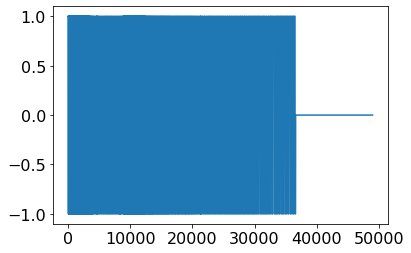

In [92]:
plt.plot(updn)